In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
hw_prefix = '/content/drive/MyDrive/nlp2022-hw1-main/nlp2022-hw1-main/hw1/stud'
hw_prefix = '.'
import string

import numpy as np
from typing import List, Tuple
import sklearn

from typing import List, Dict
import json
import torch
import random
import csv
import matplotlib.pyplot as plt
import nltk
from torch import nn
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from string import punctuation
from collections import defaultdict
from functools import partial


torch.manual_seed(42)
np.random.seed(42)
random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_tokens = set(stopwords.words('english'))
punc_tokens = set(punctuation)
stop_tokens.update(punc_tokens)
lemmatizer = WordNetLemmatizer()

#setting the embedding dimension
EMBEDDING_DIM=50

SENTENCE_MAX_LEN=50

#specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)
#setting unknown token  to handle out of vocabulary words
UNK_TOKEN = '<unk>'
PAD_TOKEN = '<pad>'
TRAIN_PATH = hw_prefix+"/../../data/train.tsv"
DEV_PATH = hw_prefix+"/../../data/dev.tsv"


cuda


[nltk_data] Downloading package omw-1.4 to /home/michele/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/michele/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/michele/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/michele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/michele/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
#creating a vocabulary with glove embeddings
def create_glove(embedding_dim=EMBEDDING_DIM):
    f = open(hw_prefix+'/glove/glove.6B.' + str(embedding_dim) + 'd.txt', 'r')
    glove = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        embedding = np.array([float(value) for value in splitLines[1:]])
        glove[word] = embedding
    return glove

#creating a vector of word embeddings and a dictionary to pair each word with an index
#the vector of embeddings will be needed in the embedding layer of the neural network
def create_embeddings(vocabulary,embedding_dim=EMBEDDING_DIM):
    vectors = []                                #creating a vector to append the vectors corresponding to words
    word2idx = dict()                           #creating a dictionary to associate each word with an index
    vectors.append(torch.rand(embedding_dim))   #creating a random vector for unknown (out of vocabulary) words
    vectors.append(torch.rand(embedding_dim))   #creating a random vector for padding
    word2idx[UNK_TOKEN] = 0                     #setting the index of the unknown token to 0
    for word,vector in vocabulary.items():      #creating the word:index entry and insert in vectors
        word2idx[word] = len(vectors)           #the word vector at the corresponding index for each word
        vectors.append(torch.tensor(vector))    #in the dictionary
    word2idx = defaultdict(lambda: 0, word2idx) #if the word we're looking for is not in the dictionary, we give the unknown token index
    vectors = torch.stack(vectors).to(device).float()   #convert the list of tensors into a tensor of tensors
    return vectors,word2idx

400003
CREATED VOCABULARY
CREATED MODEL
CREATED TRAIN DATASET
CREATED DEV DATASET
CREATED DATALOADERS


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 0   values on training set are {'mean_loss': 1.9804570756115756, 'f1': 0.04637405757553885}
            final values on the dev set are {'mean_loss': 1.9790341010422199, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 1   values on training set are {'mean_loss': 1.95222373349326, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.952214721846929, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 2   values on training set are {'mean_loss': 1.9522217019573673, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.9522127652218049, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 3   values on training set are {'mean_loss': 1.9522214907866258, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.952212556667766, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 4   values on training set are {'mean_loss': 1.9522214182130584, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.9522124837485135, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 5   values on training set are {'mean_loss': 1.952221381533277, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.9522124479110654, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 6   values on training set are {'mean_loss': 1.9522213629313878, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.9522124292457277, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 7   values on training set are {'mean_loss': 1.9522213440675003, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.9522124108292613, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 8   values on training set are {'mean_loss': 1.9522213249416143, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.9522123926616661, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 9   values on training set are {'mean_loss': 1.9522212845938547, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.9522123563264755, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 10   values on training set are {'mean_loss': 1.9522211129848774, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.952212204763934, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 11   values on training set are {'mean_loss': 1.9522217446631127, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.9522190614134882, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 12   values on training set are {'mean_loss': 1.9522237534051412, 'f1': 0.04647887653949357}
            final values on the dev set are {'mean_loss': 1.9522142644217217, 'f1': 0.04665280276581444}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 13   values on training set are {'mean_loss': 1.9522097828624012, 'f1': 0.04654752609010176}
            final values on the dev set are {'mean_loss': 1.952201895275793, 'f1': 0.04714554459451117}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 14   values on training set are {'mean_loss': 1.9521843574859283, 'f1': 0.04686779434596219}
            final values on the dev set are {'mean_loss': 1.9521772759443534, 'f1': 0.04665280276581444}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 15   values on training set are {'mean_loss': 1.9521584971920474, 'f1': 0.046993001304156214}
            final values on the dev set are {'mean_loss': 1.9521465057619927, 'f1': 0.04742998552157981}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 16   values on training set are {'mean_loss': 1.9521832785763584, 'f1': 0.04744844475151872}
            final values on the dev set are {'mean_loss': 1.9521796780488685, 'f1': 0.04744858183711473}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 17   values on training set are {'mean_loss': 1.9520143702789978, 'f1': 0.04819572875471479}
            final values on the dev set are {'mean_loss': 1.9520085512471845, 'f1': 0.047481053931411804}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 18   values on training set are {'mean_loss': 1.951977421425201, 'f1': 0.04848378455578646}
            final values on the dev set are {'mean_loss': 1.9519799937783802, 'f1': 0.047850627963383435}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 19   values on training set are {'mean_loss': 1.9519374690213047, 'f1': 0.04845798557252315}
            final values on the dev set are {'mean_loss': 1.95194118555503, 'f1': 0.04781092439803575}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 20   values on training set are {'mean_loss': 1.9517135643697048, 'f1': 0.049902835652313626}
            final values on the dev set are {'mean_loss': 1.951722362096225, 'f1': 0.04901446737060575}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 21   values on training set are {'mean_loss': 1.9514941543013185, 'f1': 0.0511410920047433}
            final values on the dev set are {'mean_loss': 1.9515172392440987, 'f1': 0.0506359195190323}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 22   values on training set are {'mean_loss': 1.9514699896613321, 'f1': 0.05216439254882225}
            final values on the dev set are {'mean_loss': 1.9514706597696516, 'f1': 0.054296124419641316}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 23   values on training set are {'mean_loss': 1.9511430156099927, 'f1': 0.0535320356436348}
            final values on the dev set are {'mean_loss': 1.951155600318829, 'f1': 0.05373216559443861}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 24   values on training set are {'mean_loss': 1.9510755255982115, 'f1': 0.05380801641638573}
            final values on the dev set are {'mean_loss': 1.9510811338345044, 'f1': 0.05429542146708211}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 25   values on training set are {'mean_loss': 1.9509823951092395, 'f1': 0.05423579024261728}
            final values on the dev set are {'mean_loss': 1.9509901940698167, 'f1': 0.05521514736045974}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 26   values on training set are {'mean_loss': 1.948507332277822, 'f1': 0.06231968085722374}
            final values on the dev set are {'mean_loss': 1.9476347303091857, 'f1': 0.11074778376043382}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 27   values on training set are {'mean_loss': 1.9203291476427853, 'f1': 0.13416607889371995}
            final values on the dev set are {'mean_loss': 1.9201694159517706, 'f1': 0.14704464435988693}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 28   values on training set are {'mean_loss': 1.915980047446031, 'f1': 0.1436540369361193}
            final values on the dev set are {'mean_loss': 1.915957262720096, 'f1': 0.1418409146158959}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 29   values on training set are {'mean_loss': 1.914310084070478, 'f1': 0.14401060734187843}
            final values on the dev set are {'mean_loss': 1.9143440307804338, 'f1': 0.12996499016617577}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 30   values on training set are {'mean_loss': 1.913379341167408, 'f1': 0.15237428019295832}
            final values on the dev set are {'mean_loss': 1.9134391658241416, 'f1': 0.1664528464604914}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 31   values on training set are {'mean_loss': 1.9109786051970261, 'f1': 0.16269449077621267}
            final values on the dev set are {'mean_loss': 1.9110392668053104, 'f1': 0.17797321961914325}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 32   values on training set are {'mean_loss': 1.9080545682173509, 'f1': 0.17917990408934317}
            final values on the dev set are {'mean_loss': 1.9082401550388535, 'f1': 0.1807133695203684}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 33   values on training set are {'mean_loss': 1.906464028096461, 'f1': 0.1912433033768499}
            final values on the dev set are {'mean_loss': 1.906655332738522, 'f1': 0.18673726159232887}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 34   values on training set are {'mean_loss': 1.9039601401968316, 'f1': 0.20961910352150998}
            final values on the dev set are {'mean_loss': 1.9041688867799922, 'f1': 0.1951844453693958}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 35   values on training set are {'mean_loss': 1.9005637053604965, 'f1': 0.2299571783173137}
            final values on the dev set are {'mean_loss': 1.9008767905961994, 'f1': 0.21910373533305905}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 36   values on training set are {'mean_loss': 1.8985766182888995, 'f1': 0.22702527604213046}
            final values on the dev set are {'mean_loss': 1.898991133325533, 'f1': 0.2145712482158311}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 37   values on training set are {'mean_loss': 1.8965831607252688, 'f1': 0.24744592608981755}
            final values on the dev set are {'mean_loss': 1.8970038890838623, 'f1': 0.22370432194298007}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 38   values on training set are {'mean_loss': 1.8947080208705023, 'f1': 0.2573746882521355}
            final values on the dev set are {'mean_loss': 1.895168669288492, 'f1': 0.23161133136944487}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 39   values on training set are {'mean_loss': 1.8934923549274822, 'f1': 0.2622403442624219}
            final values on the dev set are {'mean_loss': 1.8940375548066077, 'f1': 0.2389668332419773}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 40   values on training set are {'mean_loss': 1.8909733748697972, 'f1': 0.2775487133589488}
            final values on the dev set are {'mean_loss': 1.891516560054771, 'f1': 0.25300516484714425}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 41   values on training set are {'mean_loss': 1.8886940785816737, 'f1': 0.2915241297268207}
            final values on the dev set are {'mean_loss': 1.889328505649447, 'f1': 0.25605671431707683}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 42   values on training set are {'mean_loss': 1.8871820774707166, 'f1': 0.3004765102825668}
            final values on the dev set are {'mean_loss': 1.887845168282941, 'f1': 0.26469385888533986}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 43   values on training set are {'mean_loss': 1.8861787282503568, 'f1': 0.30238138303534307}
            final values on the dev set are {'mean_loss': 1.8868813885527513, 'f1': 0.25426380059144094}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 44   values on training set are {'mean_loss': 1.8847291432894193, 'f1': 0.29913351591617543}
            final values on the dev set are {'mean_loss': 1.8854943043503731, 'f1': 0.23428607071998261}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 45   values on training set are {'mean_loss': 1.8837185626501565, 'f1': 0.29535390604404194}
            final values on the dev set are {'mean_loss': 1.8845242956237156, 'f1': 0.25764024674854363}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 46   values on training set are {'mean_loss': 1.8828274800227238, 'f1': 0.2870870469349981}
            final values on the dev set are {'mean_loss': 1.883663695142264, 'f1': 0.235244077985594}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 47   values on training set are {'mean_loss': 1.881920356802888, 'f1': 0.27310681416969346}
            final values on the dev set are {'mean_loss': 1.8827554425516309, 'f1': 0.24070332665551408}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 48   values on training set are {'mean_loss': 1.8808784870000985, 'f1': 0.2767946582773736}
            final values on the dev set are {'mean_loss': 1.881771394753506, 'f1': 0.22825682380038867}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 49   values on training set are {'mean_loss': 1.8802681933392535, 'f1': 0.28438736937881653}
            final values on the dev set are {'mean_loss': 1.8812205649616822, 'f1': 0.2389487709052139}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 50   values on training set are {'mean_loss': 1.8726804492237803, 'f1': 0.33662847193333617}
            final values on the dev set are {'mean_loss': 1.8731640383196773, 'f1': 0.318670698848995}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 51   values on training set are {'mean_loss': 1.8622723081609704, 'f1': 0.3860281914358162}
            final values on the dev set are {'mean_loss': 1.8632319292096355, 'f1': 0.3118873571011162}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 52   values on training set are {'mean_loss': 1.8602431952298342, 'f1': 0.3624910848347615}
            final values on the dev set are {'mean_loss': 1.8612618677800283, 'f1': 0.3087855067400897}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 53   values on training set are {'mean_loss': 1.8504524733994034, 'f1': 0.39099400046270927}
            final values on the dev set are {'mean_loss': 1.8514445298399955, 'f1': 0.32964382999860137}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 54   values on training set are {'mean_loss': 1.846003144127982, 'f1': 0.42253336224393856}
            final values on the dev set are {'mean_loss': 1.8472559088704978, 'f1': 0.3378880867700191}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 55   values on training set are {'mean_loss': 1.8442988691749154, 'f1': 0.3945344158742146}
            final values on the dev set are {'mean_loss': 1.8455180457340152, 'f1': 0.37060357564174745}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 56   values on training set are {'mean_loss': 1.8429253575566051, 'f1': 0.44526006986065547}
            final values on the dev set are {'mean_loss': 1.8442024102041765, 'f1': 0.3684549964286216}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 57   values on training set are {'mean_loss': 1.8419154117395589, 'f1': 0.4515381798528018}
            final values on the dev set are {'mean_loss': 1.843187601183053, 'f1': 0.38657426585886695}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 58   values on training set are {'mean_loss': 1.8410730781135978, 'f1': 0.4686889029285054}
            final values on the dev set are {'mean_loss': 1.8424611753611078, 'f1': 0.3716183531587604}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 59   values on training set are {'mean_loss': 1.840212125306601, 'f1': 0.46157956794358085}
            final values on the dev set are {'mean_loss': 1.8415805930135642, 'f1': 0.3597152537696982}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 60   values on training set are {'mean_loss': 1.8393182725696773, 'f1': 0.4520830330677864}
            final values on the dev set are {'mean_loss': 1.8407468922700663, 'f1': 0.3815798526861462}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 61   values on training set are {'mean_loss': 1.8390237596008805, 'f1': 0.46097255445727975}
            final values on the dev set are {'mean_loss': 1.8404461274814008, 'f1': 0.37544072648383103}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 62   values on training set are {'mean_loss': 1.8316877430611915, 'f1': 0.510745225560833}
            final values on the dev set are {'mean_loss': 1.8333528673972366, 'f1': 0.4096705338953242}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 63   values on training set are {'mean_loss': 1.8291410252288147, 'f1': 0.5219216599743165}
            final values on the dev set are {'mean_loss': 1.8308614840836017, 'f1': 0.4142313208108916}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 64   values on training set are {'mean_loss': 1.827151947231083, 'f1': 0.5202170239290904}
            final values on the dev set are {'mean_loss': 1.8289889169386384, 'f1': 0.42562654382299137}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 65   values on training set are {'mean_loss': 1.825630459680662, 'f1': 0.5253805901671295}
            final values on the dev set are {'mean_loss': 1.8275436750284566, 'f1': 0.4078670600031427}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 66   values on training set are {'mean_loss': 1.8244970890191885, 'f1': 0.5243805249848118}
            final values on the dev set are {'mean_loss': 1.8264993580995372, 'f1': 0.4110080098981314}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 67   values on training set are {'mean_loss': 1.8237364703482324, 'f1': 0.5244725270612549}
            final values on the dev set are {'mean_loss': 1.825644865414295, 'f1': 0.41473111750434843}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 68   values on training set are {'mean_loss': 1.8229660856854784, 'f1': 0.5347793104243053}
            final values on the dev set are {'mean_loss': 1.8248964597885196, 'f1': 0.4112489137503231}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 69   values on training set are {'mean_loss': 1.82192224748842, 'f1': 0.5327420302057826}
            final values on the dev set are {'mean_loss': 1.823875914535841, 'f1': 0.42512229004802676}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 70   values on training set are {'mean_loss': 1.8213299232524829, 'f1': 0.5406909187263047}
            final values on the dev set are {'mean_loss': 1.82326931445733, 'f1': 0.4320700160720739}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 71   values on training set are {'mean_loss': 1.8207969922285814, 'f1': 0.5432869006423499}
            final values on the dev set are {'mean_loss': 1.8228190679390894, 'f1': 0.4260189750641077}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 72   values on training set are {'mean_loss': 1.8202001896533337, 'f1': 0.5506375068738216}
            final values on the dev set are {'mean_loss': 1.8222708841455257, 'f1': 0.41898642638368716}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 73   values on training set are {'mean_loss': 1.819430376147176, 'f1': 0.543700852699147}
            final values on the dev set are {'mean_loss': 1.8215421221699246, 'f1': 0.4182811270708227}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 74   values on training set are {'mean_loss': 1.8192059215608534, 'f1': 0.5484204850648535}
            final values on the dev set are {'mean_loss': 1.821319104734194, 'f1': 0.41523512012318586}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 75   values on training set are {'mean_loss': 1.8171684610974657, 'f1': 0.5690903405546136}
            final values on the dev set are {'mean_loss': 1.819207398528097, 'f1': 0.4636937066638504}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 76   values on training set are {'mean_loss': 1.8127575772149223, 'f1': 0.6137879853734418}
            final values on the dev set are {'mean_loss': 1.8150250122791043, 'f1': 0.4741769919423748}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 77   values on training set are {'mean_loss': 1.8090233787075505, 'f1': 0.6401366099911345}
            final values on the dev set are {'mean_loss': 1.8113171855193837, 'f1': 0.5088220295061024}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 78   values on training set are {'mean_loss': 1.8045904054746522, 'f1': 0.6820934186435385}
            final values on the dev set are {'mean_loss': 1.8070730657816432, 'f1': 0.5208197516724141}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 79   values on training set are {'mean_loss': 1.803462290239858, 'f1': 0.6834882870784658}
            final values on the dev set are {'mean_loss': 1.8060336478816692, 'f1': 0.5187829656867714}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 80   values on training set are {'mean_loss': 1.80261335844522, 'f1': 0.6884735662926743}
            final values on the dev set are {'mean_loss': 1.8052531351376178, 'f1': 0.5102948498745303}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 81   values on training set are {'mean_loss': 1.801874218406258, 'f1': 0.6983433507405509}
            final values on the dev set are {'mean_loss': 1.804492159775752, 'f1': 0.5226428251237994}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 82   values on training set are {'mean_loss': 1.8013209570895186, 'f1': 0.6948110567670963}
            final values on the dev set are {'mean_loss': 1.8040202963078444, 'f1': 0.5182083454459395}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 83   values on training set are {'mean_loss': 1.8007003074163919, 'f1': 0.7035858360254412}
            final values on the dev set are {'mean_loss': 1.8034118496052656, 'f1': 0.5239089330520293}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 84   values on training set are {'mean_loss': 1.799994050539457, 'f1': 0.7132029985834443}
            final values on the dev set are {'mean_loss': 1.802694325158392, 'f1': 0.528709016424406}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 85   values on training set are {'mean_loss': 1.7998186716666589, 'f1': 0.7129000926064059}
            final values on the dev set are {'mean_loss': 1.8026447684381601, 'f1': 0.5277461068216872}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 86   values on training set are {'mean_loss': 1.7992189048410772, 'f1': 0.7076172114174124}
            final values on the dev set are {'mean_loss': 1.8018944119112974, 'f1': 0.5167553967251358}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 87   values on training set are {'mean_loss': 1.7989076677259508, 'f1': 0.6943732817286212}
            final values on the dev set are {'mean_loss': 1.801652176892832, 'f1': 0.51032515006479}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 88   values on training set are {'mean_loss': 1.798454238818242, 'f1': 0.6955304690889675}
            final values on the dev set are {'mean_loss': 1.8011757901914434, 'f1': 0.5087537376396151}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 89   values on training set are {'mean_loss': 1.7980337273943556, 'f1': 0.6961723836818496}
            final values on the dev set are {'mean_loss': 1.8008882758015132, 'f1': 0.5097403597224798}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 90   values on training set are {'mean_loss': 1.7977636258680743, 'f1': 0.6501148633855349}
            final values on the dev set are {'mean_loss': 1.8006128080204782, 'f1': 0.47519600184114563}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 91   values on training set are {'mean_loss': 1.797197936655401, 'f1': 0.6580009533964335}
            final values on the dev set are {'mean_loss': 1.7999679556968067, 'f1': 0.49165935890177864}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 92   values on training set are {'mean_loss': 1.7971828452833407, 'f1': 0.6770296958326929}
            final values on the dev set are {'mean_loss': 1.8000427238129872, 'f1': 0.4782914527636901}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 93   values on training set are {'mean_loss': 1.7969904317960634, 'f1': 0.667915053372026}
            final values on the dev set are {'mean_loss': 1.799862454977812, 'f1': 0.5003083674439932}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 94   values on training set are {'mean_loss': 1.7966242017326775, 'f1': 0.6520275715290061}
            final values on the dev set are {'mean_loss': 1.7995025270418235, 'f1': 0.4716149600384972}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 95   values on training set are {'mean_loss': 1.7964553007712731, 'f1': 0.659522438463279}
            final values on the dev set are {'mean_loss': 1.7993452991971393, 'f1': 0.49273417378703677}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 96   values on training set are {'mean_loss': 1.7963800894035087, 'f1': 0.6521376702078493}
            final values on the dev set are {'mean_loss': 1.799269834490559, 'f1': 0.4804501101375349}
------------------------------PATIENCE---------------------------------------------


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 97   values on training set are {'mean_loss': 1.7958380921856387, 'f1': 0.652392824191998}
            final values on the dev set are {'mean_loss': 1.7988023700694202, 'f1': 0.4984090871271875}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 98   values on training set are {'mean_loss': 1.7957178896600074, 'f1': 0.6974464956425324}
            final values on the dev set are {'mean_loss': 1.7987729440402387, 'f1': 0.5065466020652161}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Epoch 99   values on training set are {'mean_loss': 1.7955048527036395, 'f1': 0.6963507489054469}
            final values on the dev set are {'mean_loss': 1.7984168551908903, 'f1': 0.5103740804102823}


/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/michele/anaconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


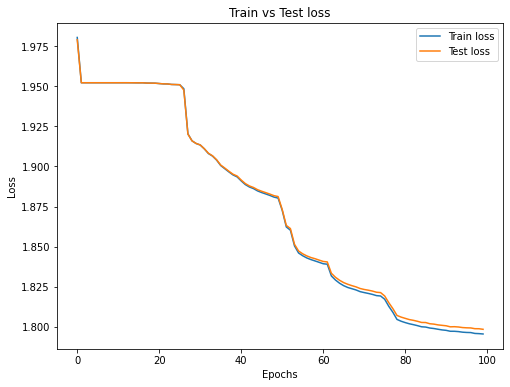

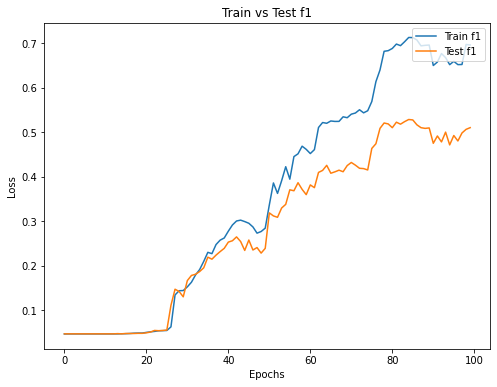

'\nmodel.load_state_dict(torch.load(model_path,map_location=device))\nmodel.predict(read_dataset(DEV_PATH)[0])\n\n\n#'

In [11]:
class SentenceDataset(Dataset):

    def __init__(self,vectors,word2idx,sentences_path=None,sentences=None,lemmatization=True,
                 test=False,class2id={"O": 0, "B-PER": 1, "B-LOC": 2, "B-GRP": 3, "B-CORP": 4, "B-PROD": 5, #indexing output classes
                    "B-CW": 6, "I-PER": 7, "I-LOC": 8, "I-GRP": 9, "I-CORP": 10, "I-PROD": 11, "I-CW": 12, "<pad>":13}):
        file_output = self.read_file(sentences_path) if sentences_path else self.read_sentences(sentences)
        self.embedding_vectors = vectors
        self.word2idx = word2idx
        self.test = test
        self.w_lemmatization = lemmatization
        self.word_count = dict()
        self.extract_sentences(file_output)
        #self.remove_most_frequent(percentage=1)
        # encoding of classes
        self.class2id = class2id
        self.id2class = {v: k for (k, v) in self.class2id.items()}

    #function to remove the most frequent words in the corpus (ideally the less discriminative, only acting as noise, but
    #it didn't work great so I'm not sure
    def remove_most_frequent(self,percentage):
        #print("STARTING MOST FREQUENT")
        sorted_counts = sorted(self.word_count.items(),key=lambda x:x[1],reverse=True)  #sort dict with word counts
        total_words = len(sorted_counts)                                                #check the total number of words
        start_index = int((total_words/100)*percentage)                                 #compute the starting point to
        sorted_counts = sorted_counts[start_index:]                                     #exclude the wanted percentage
        sorted_counts = set([x[0] for x in sorted_counts])                              #transforming in set to make
        sentences = []                                                                  #checking the presence efficient (O(1))
        #print("STARTING REMOVING")
        for sample in self.sentences:
            sentence = sample[0]
            new_sentence = []
            for word,pos in sentence:
                if word in sorted_counts:
                    new_sentence.append((word,pos))
            sentences.append((new_sentence,sample[1],sample[2]))
        self.sentences = sentences


    #little function to read a file given the path
    def read_file(self,path):
        sentences = list()
        with open(path) as file:
            tsv_file = csv.reader(file, delimiter="\t")
            for idx,line in enumerate(tsv_file):
                if len(line) > 0:
                    if line[0] == '#':
                        
                        sentences.append(dict())
                        sentences[-1]["id"] = line[2]
                        sentences[-1]["text"] = []
                        sentences[-1]["labels"] = []
                    else:
                        sentences[-1]["text"].append(line[0])
                        sentences[-1]["labels"].append(line[1])
        #print([len(sentences[i]['text']) for i in range(len(sentences))])
        return sentences

    def read_sentences(self,sentences):
        sents = list()
        for idx,line in enumerate(sentences):
            d = dict()
            d["id"] = idx
            d["text"] = line
            d["labels"] = ["O" for token in line]
            sents.append(d)
        return sents

    #function to extract the sentences from the dictionary of samples
    def extract_sentences(self,file_output):
        self.sentences = list()                 #creating a list to store the instances in the dataset
        for instance in file_output:
            processed = self.text_preprocess(instance)  #preprocessing of the sentence
            labels = 'UNKNOWN'   #this is needed to make the system able to give a prediction without having a ground truth
            if 'labels' in instance: #then if there is a ground truth we take it
                labels = processed['labels']
            self.sentences.append((processed["text"], labels, id))           #append a triple (sentence,label,id) which are all the informations we need
        if not self.test: random.Random(42).shuffle(self.sentences)         #for the training phase, shuffle data to avoid bias relative to data order
        #print(self.sentences)

    #function to convert the pos extracted by nltk to the pos required by the very same library for lemmatization
    #I also use it to give pos='' to punctuation
    def get_standard(self,pos):
        if pos[0] == 'V': return wordnet.VERB
        if pos[0] == 'R': return wordnet.ADV
        if pos[0] == 'N': return wordnet.NOUN
        if pos[0] == 'J': return wordnet.ADJ
        return ''

    #function which includes all the preprocessing steps for the sentences, which are tokenization,
    #stopwords and punctuation removal,pos tagging and lemmatization
    def text_preprocess(self,sentence):
        text = sentence["text"]
        labels = sentence["labels"]
        sent = [(text[i],labels[i]) for i in range(len(text))]# if text[i] not in string.punctuation and text[i] not in stop_tokens]
        #sent = [(text[i],labels[i]) for i in range(len(text)) if labels[i] != 'O']
        sentence["text"] = [pair[0] for pair in sent]
        sentence["labels"] = [pair[1] for pair in sent]
        return sentence
        '''
        standard_tokens = [(token,self.get_standard(pos)) for token,pos in tokens_n_pos]
        clean_standard = [(token,pos) for token,pos in standard_tokens if pos != '']   #light stopwords removal
        clean_standard2 = [(token, pos) for token, pos in standard_tokens if token not in stop_tokens]  # full stopwords removal
        if self.w_lemmatization:            #choosing if applying lemmatization
            lemmatized = [(lemmatizer.lemmatize(token.lower(),pos),pos) if pos != '' else (lemmatizer.lemmatize(token.lower()),'') for token,pos in clean_standard2]
            #print("STARTED BUILDING WORD COUNT")
            for lemma,pos in lemmatized:
                if lemma in self.word_count:
                    self.word_count[lemma] += 1
                else:
                    self.word_count[lemma] = 1
            return lemmatized
        return [(word,pos) for word,pos in clean_standard2]
        '''




    #function to return the number of instances contained in the dataset
    def __len__(self):
        return len(self.sentences)

    #function to get the i-th instance contained in the dataset
    def __getitem__(self, idx):
        return self.sentences[idx]

    #custom dataloader which incorporates the collate function
    def dataloader(self,batch_size):
        return DataLoader(self,batch_size=batch_size,collate_fn=partial(self.collate,self.word2idx))

        #function to map each lemma,pos in a sentence to their indexes
    def sent2idx(self ,sent, word2idx):
        #return torch.tensor([word2idx[word] for word,pos in sent]) #in the case i'm not using pos I just return a placeholder for pos
        return torch.tensor([word2idx[word] for word in sent])



    #custom collate function, used to create the batches to give as input to the nn
    #it's needed because we are dealing with sentences of variable length and we need padding
    #to be sure that each sentence in a batch has the same length, which is necessary since
    #neural networks need fixed dimension inputs
    def collate(self,word2idx, data):
        X = [self.sent2idx(instance[0], word2idx) for instance in data]                             #extracting the input sentence
        X_len = torch.tensor([x.size(0) for x in X], dtype=torch.long).to(device)
        y = [self.sent2idx(instance[1], self.class2id) for instance in data]
        ids = [instance[2] for instance in data]                                                    #extracting the sentence ids
        X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=1).to(device)        #padding all the sentences to the maximum length in the batch (forcefully max_len)
        y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=self.class2id[PAD_TOKEN]).to(device)              #extracting the ground truth
        return X, X_len,y, ids


#Model class
#class StudentModel(nn.Module,Model):        #needed for testing
class StudentModel(nn.Module):             #needed for training

    #constructor method, for which are needed the word embedding vectors, the dimensions of the two linear
    #layers, the dropout probabilty p, a flag to choose if the lstm layer must be bidirectonal, the number
    #of layers of the lstm layer and the loss function (but these last 4 already have a default value)
    def __init__(self,embeddings,   #word embedding vectors
                 pos_embeddings=None,    #pos embedding vectors
                 hidden1=128,           #dimension of the first hidden layer
                 hidden2=128,           #dimension of the second hidden layer
                 #hidden3=128,
                 p=0.0,             #probability of dropour layer
                 bidirectional=False,   #flag to decide if the LSTM must be bidirectional
                 lstm_layers=1,         #layers of the LSTM
                 loss_fn=torch.nn.CrossEntropyLoss(ignore_index=0),
                 num_classes=13):   #loss function
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings,freeze=False)
        self.pos_embeddings = None if pos_embeddings == None else nn.Embedding.from_pretrained(pos_embeddings,freeze=False)     #choose if creating or not an embedding layer
                                                                               #based on wether pos embeddings were created
        input_dim = embeddings.size(1) if not self.pos_embeddings else embeddings.size(1)+pos_embeddings.size(1)                #or not
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden1, num_layers=lstm_layers, batch_first=True, bidirectional=bidirectional)
        hidden1 = hidden1*2 if bidirectional else hidden1
        self.lin1 = nn.Linear(hidden1, hidden2)
        self.lin2 = nn.Linear(hidden2,num_classes)
        #self.lin3 = nn.Linear(hidden3,num_classes)
        self.loss_fn = loss_fn
        self.dropout = nn.Dropout(p=p)
        self.num_classes = num_classes
    #forward method, automatically called when calling the instance
    #it takes the Xs and their length in batches
    def forward(self,X,X_len):
        #lemmas,pos = X[...,0],X[...,1]                                  #separating pos from lemmas
        embeddings = self.embedding(X)                                #expanding the words from indices to embedding vectors
        '''
        if self.pos_embeddings != None:                                     #in the case I'm using pos embeddings, I pass their indexes through their own embedding layer
            pos_embeddings_out1 = self.pos_embeddings(pos)                 #and then concatenate them to the corresponding words
            
            embedding1 = torch.cat([embedding,pos_embeddings_out1],dim=-1)
        '''
        #embeddings = embeddings.unsqueeze(1)
        lstm_out = self.lstm(embeddings)[0]
        lstm_out = lstm_out.squeeze()
        batch_size, sentence_len, hidden_size = lstm_out.shape  #sentence length here is taken to remove padding
        flattened1 = lstm_out.reshape(-1, hidden_size)        #the output of the lstm is flattened (batch size,sentence length,lstm output dimension)->
                        #                                       (batch size,sentence length*lstm output dimension)
        last_word_relative_indices = X_len - 1                #in order to have the last index of each sentence in the batch (excluding padding), we subtract one to the length
        sentences_offsets = torch.arange(batch_size, device=device) * sentence_len   #we compute the offsets, or absolute indexes, where each sentence starts
        vec_sum_index = sentences_offsets + last_word_relative_indices     #we take the last token of each sentence, which is the hidden
                                                                            #state of the LSTM which summarize the content of the sentence
        #vec_sum = flattened1[vec_sum_index]                         #we use the index to retrieve the vector which summarizes the sentence
        ##out = self.dropout(torch.cat([vec_sum1,vec_sum2],dim=-1))
        out = self.dropout(lstm_out)
        out = torch.relu(out)
        #print(out.size())
        out = self.lin1(out)
        out = self.dropout(out)
        out = torch.relu(out)
        out = self.lin2(out)
        #out = self.dropout(out)
        #out = torch.relu(out)
        #out = self.lin3(out)
        out = out.squeeze(1)
        #print(out.size())
        out = torch.softmax(out,dim=-1) if self.num_classes > 1 else torch.sigmoid(out)
        return out

    def predict(self, tokens: List[List[str]]) -> List[List[str]]:
        # STUDENT: implement here your predict function
        # remember to respect the same order of tokens!
        batch_size = 32
        predictions = list()
        dataset = SentenceDataset(sentences=tokens, vectors=embeddings, word2idx=word2idx, test=True)
        dataloader = dataset.dataloader(batch_size)
        for batch in dataloader:
            batch_x = batch[0]
            batch_xlen = batch[1]
            ids = batch[3]
            logits = self.forward(batch_x, batch_xlen)
            logits = logits.view(-1, logits.shape[-1])
            preds = torch.argmax(logits, dim=1)
            preds = torch.reshape(preds, (batch_x.size(0), -1))
            for i in range(len(batch_x)):
                prediction = []
                for j in range(len(batch_x[i])):
                    if j < batch_xlen[i]:
                        # print(preds)
                        # print(preds[i])
                        prediction.append(dataset.id2class[preds[i][j].item()])
                predictions.append(prediction)

        print(len(tokens), len(predictions))
        print(tokens)
        print(predictions)
        return predictions

#trainer class
class Trainer():

    def __init__(self,model,optimizer):
        self.model = model
        self.optimizer = optimizer

    #train function, takes two dataloaders for trainset and devset in order to train on the trainset and
    #check at every epoch how the training is affecting performance on the dev set, to avoid overfitting
    #I use the patience mechanism to stop after 5 times the accuracy on devset goes down, since I noticed
    #that after that point it just gets worse
    def train(self,train_loader, dev_loader,patience, epochs=10):
        loss_history = [[], []]             #lists to save trainset and devset loss in order to plot the graph later
        f1_history = [[], []]         #lists to save trainset and devset accuracy in order to plot the graph later
        patience_counter = 0                #counter to implement patience
        for i in range(epochs):
            losses = []                     #list to save the loss for each batch
            hit = 0                         #counter for correct predictions
            total = 0                       #counter for all predictions
            f1s = []
            for batch in train_loader:
                batch_x = batch[0]         #separating first from second sentences
                batch_xlen = batch[1]      #separating lengths of first and second sentences
                labels = batch[2]          #taking the ground truth
                ids = batch[3]
                self.optimizer.zero_grad()  #setting the gradients to zero for each batch
                logits = self.model(batch_x, batch_xlen) #predict
                logits = torch.flatten(logits) if self.model.num_classes == 1 else logits.view(-1, logits.shape[-1])
                
                labels = labels.view(-1)
                #print(logits.size(),labels.size())
                #print(logits)
                #print(labels)
                loss = self.model.loss_fn(logits.float(), labels.float()) if self.model.num_classes == 1 else  self.model.loss_fn(logits, labels)             #calculating the loss
                #max_logits = 
                edit_logits = torch.round(logits) if self.model.num_classes == 1 else torch.argmax(logits, dim=1)
                average = "binary" if self.model.num_classes == 1 else "macro"
                f1s.append(sklearn.metrics.f1_score(labels.cpu().detach().numpy(),edit_logits.cpu().detach().numpy(),average=average,
                                                    labels=range(self.model.num_classes-1)))
                '''
                for j in range(len(logits)):                                      #checking the number of hits in order to compute accuracy
                    total += 1
                    if torch.argmax(logits[j]) == labels[j]: hit += 1
                '''
                loss.backward()             #backpropagating the loss
                self.optimizer.step()       #adjusting the model parameters to the loss
                losses.append(loss.item())  #appending the losses to losses
            '''
            accuracy = hit/total            #computing accuracy
            accuracy_history[0].append(accuracy)    #appending accuracy to accuracy history
            '''
            f1 = sum(f1s)/len(f1s)
            f1_history[0].append(f1)
            mean_loss = sum(losses) / len(losses)   #computing the mean loss for each epoch
            loss_history[0].append(mean_loss)       #appending the mean loss of each epoch to loss history
            metrics = {'mean_loss': mean_loss, 'f1': f1}    #displaying results of the epoch
            print(f'Epoch {i}   values on training set are {metrics}')
            #the same exact process is repeated on the instances of the devset, minus gradient backpropagation and optimization of course
            hit = 0
            total = 0
            f1s = []
            with torch.no_grad():
                #RESET LOSSES????
                for batch in dev_loader:
                    batch_x = batch[0]
                    batch_xlen = batch[1]
                    labels = batch[2]
                    ids = batch[3]
                    logits = self.model(batch_x, batch_xlen)
                  
                    logits = torch.flatten(logits) if self.model.num_classes == 1 else logits.view(-1, logits.shape[-1])
                    labels = labels.view(-1)
                    edit_logits = torch.round(logits) if self.model.num_classes == 1 else torch.argmax(logits, dim=1)
                    average = "binary" if self.model.num_classes == 1 else "macro" 
                    loss = self.model.loss_fn(logits.float(), labels.float()) if self.model.num_classes == 1 else  self.model.loss_fn(logits, labels)             #calculating the loss
                    losses.append(loss.item())
                    f1s.append(sklearn.metrics.f1_score(labels.cpu().detach().numpy(), edit_logits.cpu().detach().numpy()
                                                        ,average=average,labels=range(self.model.num_classes-1)))
                    '''
                    for j in range(len(logits)):
                        total += 1
                        if torch.argmax(logits[j]) == labels[j]: hit += 1
                    '''
            mean_loss = sum(losses) / len(losses)
            loss_history[1].append(mean_loss)
            f1 = sum(f1s) / len(f1s)
            f1_history[1].append(f1)
            metrics = {'mean_loss': mean_loss, 'f1': f1}
            print(f'            final values on the dev set are {metrics}')

            if len(f1_history[1]) > 1 and f1_history[1][-1] < f1_history[1][-2]:
                patience_counter += 1
                if patience == patience_counter:
                    print('-----------------------------EARLY STOP--------------------------------------------')
                    break
                else:
                    print('------------------------------PATIENCE---------------------------------------------')

        return {
            'loss_history': loss_history,
            'f1_history': f1_history
        }



def read_dataset(path: str) -> Tuple[List[List[str]], List[List[str]]]:

    tokens_s = []
    labels_s = []

    tokens = []
    labels = []

    with open(path) as f:

        for line in f:

            line = line.strip()

            if line.startswith("#\t"):
                tokens = []
                labels = []
            elif line == "":
                tokens_s.append(tokens)
                labels_s.append(labels)
            else:
                token, label = line.split("\t")
                tokens.append(token)
                labels.append(label)

    assert len(tokens_s) == len(labels_s)

    return tokens_s, labels_s

#utility function to plot accuracy and loss
def plot_logs(history,param):
    plt.figure(figsize=(8, 6))
    train_param = history[0]
    test_param = history[1]
    plt.plot(list(range(len(train_param))), train_param, label='Train '+param)
    plt.plot(list(range(len(test_param))), test_param, label='Test '+param)
    plt.title('Train vs Test '+param)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.show()
model_path = hw_prefix+"/../../model/myModel.ckpt"
glove = create_glove()                                          #create glove dictionary
embeddings,word2idx = create_embeddings(glove)                  #create and indexing embeddings
print(len(embeddings))
print("CREATED VOCABULARY")
binaryModel = StudentModel(embeddings,bidirectional=False,hidden1=128,hidden2=128,lstm_layers=2,p=0,loss_fn=nn.CrossEntropyLoss(ignore_index=13),
                     num_classes=14).to(device)         #instantiating the model

#simpleModel = StudentModel(embeddings,bidirectional=False,hidden1=128,hidden2=128,lstm_layers=1,p=0.5,loss_fn=nn.CrossEntropyLoss(ignore_index=0),
#                     num_classes=7).to(device)         #instantiating the model

#bioModel = StudentModel(embeddings,bidirectional=True,hidden1=128,hidden2=128,hidden3=128,lstm_layers=1,p=0,loss_fn=nn.CrossEntropyLoss(ignore_index=2),
#                     num_classes=3).to(device)         #instantiating the model
print("CREATED MODEL")
#'''
binaryClass2id = {"O":0,"B-PER": 1, "B-LOC": 1, "B-GRP": 1, "B-CORP": 1, "B-PROD": 1, #indexing output classes
                    "B-CW": 1, "I-PER": 1, "I-LOC": 1, "I-GRP": 1, "I-CORP": 1, "I-PROD": 1, "I-CW": 1, "<pad>":2}

simpleClass2id = {"O":0,"B-PER": 1, "B-LOC": 2, "B-GRP": 3, "B-CORP": 4, "B-PROD": 5, #indexing output classes
                    "B-CW": 6, "I-PER": 1, "I-LOC": 2, "I-GRP": 3, "I-CORP": 4, "I-PROD": 5, "I-CW": 6, "<pad>":7}

bioClass2id = {"B-PER": 0, "B-LOC": 0, "B-GRP": 0, "B-CORP": 0, "B-PROD": 0, #indexing output classes
                    "B-CW": 0, "I-PER": 1, "I-LOC": 1, "I-GRP": 1, "I-CORP": 1, "I-PROD": 1, "I-CW": 1, "<pad>":2}

afterClass2id = {"B-PER": 0, "B-LOC": 1, "B-GRP": 2, "B-CORP": 3, "B-PROD": 4, #indexing output classes
                    "B-CW": 5, "I-PER": 6, "I-LOC": 7, "I-GRP": 8, "I-CORP": 9, "I-PROD": 10, "I-CW": 11, "<pad>":12}

bin_train_dataset = SentenceDataset(sentences_path=TRAIN_PATH,vectors=embeddings,word2idx=word2idx) #instantiating the training dataset
#simple_train_dataset = SentenceDataset(sentences_path=TRAIN_PATH,vectors=embeddings,word2idx=word2idx,class2id=simpleClass2id) #instantiating the training dataset
#bio_train_dataset = SentenceDataset(sentences_path=TRAIN_PATH,vectors=embeddings,word2idx=word2idx,class2id=bioClass2id) #instantiating the training dataset
print("CREATED TRAIN DATASET")

bin_dev_dataset = SentenceDataset(sentences_path=DEV_PATH,vectors=embeddings,word2idx=word2idx,test=True)       #instantiating the dev dataset
#simple_dev_dataset = SentenceDataset(sentences_path=DEV_PATH,vectors=embeddings,word2idx=word2idx,test=True,class2id=simpleClass2id)       #instantiating the dev dataset
#bio_dev_dataset = SentenceDataset(sentences_path=DEV_PATH,vectors=embeddings,word2idx=word2idx,test=True,class2id=bioClass2id)
print("CREATED DEV DATASET")
bin_train_dl = bin_train_dataset.dataloader(batch_size=32)                         #instantiating the dataloaders
bin_dev_dl = bin_dev_dataset.dataloader(batch_size=32)

#simple_train_dl = simple_train_dataset.dataloader(batch_size=64)                         #instantiating the dataloaders
#simple_dev_dl = simple_dev_dataset.dataloader(batch_size=64)

#bio_train_dl = bio_train_dataset.dataloader(batch_size=16)                         #instantiating the dataloaders
#bio_dev_dl = bio_dev_dataset.dataloader(batch_size=16)
print("CREATED DATALOADERS")
optimizer = torch.optim.Adam(binaryModel.parameters(), lr=0.001, weight_decay=0.00) #instantiating the optimizer
trainer = Trainer(model=binaryModel,optimizer=optimizer)                                              #instantiating the trainer

#optimizer = torch.optim.Adam(simpleModel.parameters(), lr=0.001, weight_decay=0.00) #instantiating the optimizer
#trainer = Trainer(model=simpleModel,optimizer=optimizer)                                              #instantiating the trainer

#optimizer = torch.optim.Adam(bioModel.parameters(), lr=0.0001, weight_decay=0.00) #instantiating the optimizer
#trainer = Trainer(model=bioModel,optimizer=optimizer)                                              #instantiating the trainer

histories = trainer.train(train_loader=bin_train_dl,dev_loader=bin_dev_dl,patience=100,epochs=100)    #training
params = ['loss', 'f1']                                                   #plotting the metrics
for param in params:
    plot_logs(histories[param + '_history'], param)
#torch.save(binaryModel.state_dict(), model_path)                                      #saving the model
#torch.save(simpleModel.state_dict(), model_path)                                      #saving the model
torch.save(binaryModel.state_dict(), model_path)                                      #saving the model

'''
model.load_state_dict(torch.load(model_path,map_location=device))
model.predict(read_dataset(DEV_PATH)[0])


#'''

